# pomegranate / libpgm comparison

authors: Jacob Schreiber (jmschreiber91@gmail.com)

<a href="https://github.com/CyberPoint/libpgm">libpgm</a> is a python package for creating and using Bayesian networks. I was unable to figure out how to use libpgm to do inference properly without raising errors, but I was able to get structure learning working. libpgm uses constraints for structure learning, a process which is not probabilistic, but can be asymptoptically more efficient (between O(n^2) and O(n^3) as opposed to exponential). To my knowledge, they do not have exact structure learning implemented, likely due to the super-exponential nature of the naive algorithm.

pomegranate has both the exact structure learning problem, and the Chow-Liu tree approximation, implemented. The exact structure learning problem uses an efficient dynamic programming solution to reduce the complexity from super-exponential to exponential in time with the number of variables. The Chow-Liu tree approximation finds the best tree which spans all variables.

Lets compare the structure learning task in pomegranate versus the structure learning task in libpgm for different numbers of variables to compare these speed of the two packages.

In [2]:
%pylab inline
import seaborn, time
seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


Lets first compare the two packages based on number of variables.

In [14]:
from pomegranate import BayesianNetwork
from libpgm.pgmlearner import PGMLearner

libpgm_time = []
pomegranate_time = []
pomegranate_cl_time = []

for i in range(2, 15):
    tic = time.time()
    X = numpy.random.randint(2, size=(10000, i))
    model = BayesianNetwork.from_samples(X, algorithm='exact')
    pomegranate_time.append(time.time() - tic)

    tic = time.time()
    model = BayesianNetwork.from_samples(X, algorithm='chow-liu')
    pomegranate_cl_time.append(time.time() - tic)

    X = [{j : X[i, j] for j in range(X.shape[1])} for i in range(X.shape[0])]
    learner = PGMLearner()

    tic = time.time()
    model = learner.discrete_constraint_estimatestruct(X)
    libpgm_time.append(time.time() - tic)

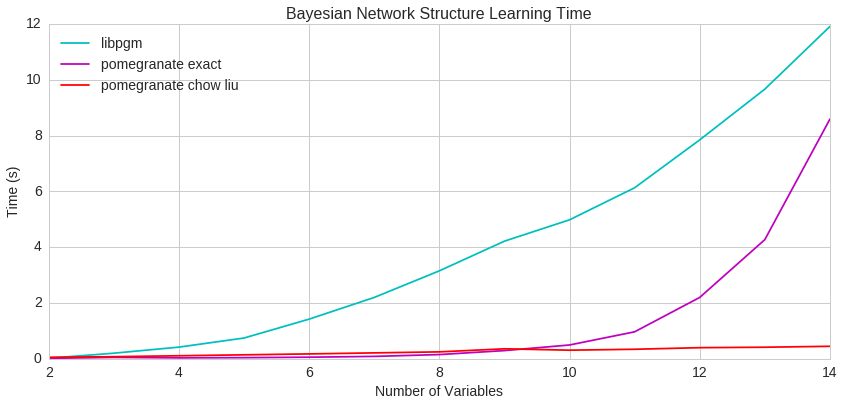

In [16]:
plt.figure(figsize=(14, 6))
plt.title("Bayesian Network Structure Learning Time", fontsize=16)
plt.xlabel("Number of Variables", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.plot(range(2, 15), libpgm_time, c='c', label="libpgm")
plt.plot(range(2, 15), pomegranate_time, c='m', label="pomegranate exact")
plt.plot(range(2, 15), pomegranate_cl_time, c='r', label="pomegranate chow liu")
plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We can see many expected results from this graph. libpgm implements a quadratic time algorithm, and it appears that the growth is roughly quadratic. The exact algorithm in pomegranate is an exponential time algorithm, and so while it does have an efficient implementation that causes the it to be much faster than libpgm's algorithm for small numbers of variables, eventually it will become slower. Lastly, the chow-liu tree algorithm is far faster than both other algorithms because it is finding the best tree approximation. While it is a quadratic time algorithm, it is also a simpler one.

Lets now compare the speed on different numbers of samples.

In [22]:
libpgm_time = []
pomegranate_time = []
pomegranate_cl_time = []

x = 10, 25, 100, 250, 1000, 2500, 10000, 25000, 100000, 250000, 1000000
for i in x:
    tic = time.time()
    X = numpy.random.randint(2, size=(i, 10))
    model = BayesianNetwork.from_samples(X, algorithm='exact')
    pomegranate_time.append(time.time() - tic)

    tic = time.time()
    model = BayesianNetwork.from_samples(X, algorithm='chow-liu')
    pomegranate_cl_time.append(time.time() - tic)

    X = [{j : X[i, j] for j in range(X.shape[1])} for i in range(X.shape[0])]
    learner = PGMLearner()

    tic = time.time()
    model = learner.discrete_constraint_estimatestruct(X)
    libpgm_time.append(time.time() - tic)

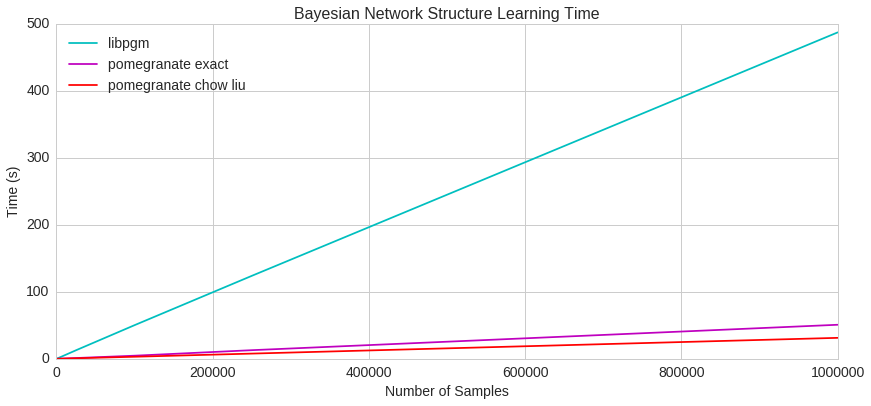

In [23]:
plt.figure(figsize=(14, 6))
plt.title("Bayesian Network Structure Learning Time", fontsize=16)
plt.xlabel("Number of Samples", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.plot(x, libpgm_time, c='c', label="libpgm")
plt.plot(x, pomegranate_time, c='m', label="pomegranate exact")
plt.plot(x, pomegranate_cl_time, c='r', label="pomegranate chow liu")
plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

It looks like when fitting for the same number of variables that pomegranate is able to scale much better than libpgm is. This could mean that for large datasets, pomegranate is much faster than libpgm even though it has a worse theoretical notation.

However, it's also important to note that this isn't exactly a fair comparison because they are two different algorithms. libpgm is implementing the constraint based structure learning algorithm which is quadratic in time, and pomegranate is using an exact structure learning algorithm which is exponential in time. However, this benchmark should lay out some practical speed differences when deciding which package to use.